In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNet
import xgboost as xgb
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [211]:
df_train = pd.read_csv('/Users/dominicdebiaso/Development/datasets/kaggle_house_prices_train.csv')
df_test = pd.read_csv('/Users/dominicdebiaso/Development/datasets/kaggle_house_prices_test.csv')

### EDA

In [18]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [19]:
print("Feature difference btwn datasets",list(set(df_train.columns) - set(df_test.columns)))

('Feature difference btwn datasets', ['SalePrice'])


In [20]:
# Missing values
df_train.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

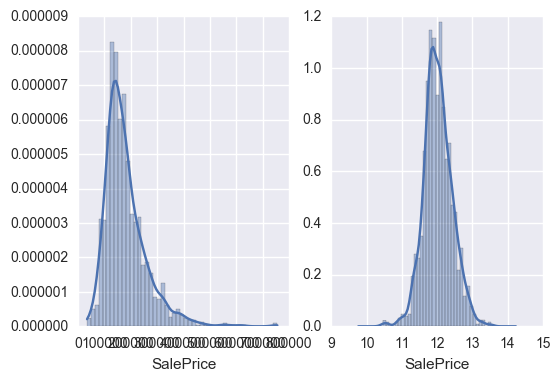

In [21]:
# Distribution of target variable before and after log transformation
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.distplot(df_train.SalePrice, ax=ax1)
sns.distplot(np.log(df_train.SalePrice), ax=ax2)

### Data Preprocessing 

In [212]:
## Feature scaling
# Numerical features with a mean=0 and stdev=1 
def scale_train_features(df):
    for col_var in df.select_dtypes(include=[np.number]).drop('SalePrice', 1).columns:
        df[col_var] = StandardScaler().fit_transform(df[col_var])
    return df
def scale_test_features(df):
    for col_var in df.select_dtypes(include=[np.number]).columns:
        df[col_var] = StandardScaler().transform(df[col_var])
    return df

# numerical_features = df_train.select_dtypes(include=[np.number]).drop(['SalePrice'], axis=1).columns
# df_train.loc[:, numerical_features] = StandardScaler().fit_transform(df_train.loc[:, numerical_features])
# df_test.loc[:, numerical_features] = StandardScaler().transform(df_test.loc[:, numerical_features])

## Standardization/ Normal distribution
# Log transform variables that have a skew greater than 0.8 
# Standardize to follow Gaussian dist of mean=0 and stdev=1
# Note: Normalizing is used to get values btwn 0 and 1
def standardize_values(df):
    for col_var in df.select_dtypes(include=[np.number]):
        if df[col_var].skew(skipna=True) > 0.8:
            df[col_var] = np.log1p(df[col_var])
        else:
            print("{} transformation not needed").format(col_var)
    return df

## Convert categorical variables to numerical
def convert_categoricals(df):
    for cat_col in df.select_dtypes(include=['object']):
        df[cat_col] = pd.factorize(df[cat_col])[0]
    return df

## Fill NaNs with mean()
def fill_nans(df):
    return df.fillna(df.mean())

In [213]:
## Transform data for models
train = fill_nans(convert_categoricals(standardize_values(df_train)))
test = fill_nans(convert_categoricals(standardize_values(df_test)))

# Create matrices
X_train = train.iloc[:,:-1].drop('Id', 1)
print(X_train.shape)
y_train = train.iloc[:,-1]
print(y_train.shape)
X_test = test.drop('Id', 1)
print(X_test.shape)

Id transformation not needed
OverallQual transformation not needed
OverallCond transformation not needed
YearBuilt transformation not needed
YearRemodAdd transformation not needed
BsmtFullBath transformation not needed
FullBath transformation not needed
HalfBath transformation not needed
BedroomAbvGr transformation not needed
TotRmsAbvGrd transformation not needed
Fireplaces transformation not needed
GarageYrBlt transformation not needed
GarageCars transformation not needed
GarageArea transformation not needed
MoSold transformation not needed
YrSold transformation not needed
Id transformation not needed
LotFrontage transformation not needed
OverallQual transformation not needed
OverallCond transformation not needed
YearBuilt transformation not needed
YearRemodAdd transformation not needed
BsmtFullBath transformation not needed
FullBath transformation not needed
HalfBath transformation not needed
BedroomAbvGr transformation not needed
GarageYrBlt transformation not needed
GarageCars tra

### Models 

In [ ]:
## Regularization used to handle collinearity, filter out noise from data, and prevent overfitting.
# Regularization introduces additional information, bias, to penalize extreme parameter weights.
# 'alpha' parameter contols the degree of sparsity of coefficiients estimated
# as alpha increases, the model complexity is reduced however
# high values reduce overfitting, values nearing 5 can lead to underfitting

## RMSE vs MAE 
# Squared error penalizes large deviations more and produces larger errors (emphasizes extremes)
# MAE causes the stdevs to average out and is able to handle outliers since it assigns equal weight
# https://www.quora.com/What-is-the-difference-between-squared-error-and-absolute-error

In [214]:
## RidgeCV
# L2 adds the squared sum of weights to cost function
ridge = RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
np.sqrt(-cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error')).mean()

0.13920804026746608

In [215]:
## LassoCV
# L1 adds the sum of the sbsolute value of the weights which yields sparse feature fectors that may be zero
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
np.sqrt(-cross_val_score(lasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error')).mean()

0.13882805250658239

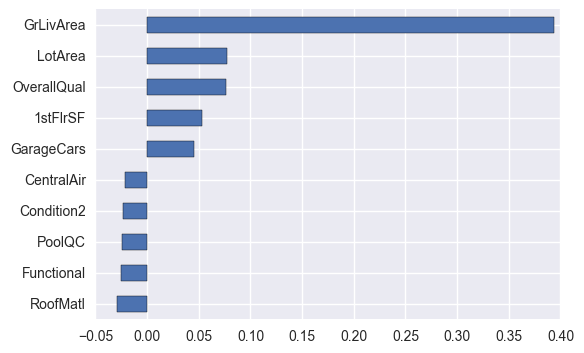

In [216]:
# L1 Feature Importance
lasso.fit(X_train, y_train)
lasso_feats = pd.Series(lasso.coef_, index=X_train.columns).sort_values()
lasso_feats = pd.concat([lasso_feats.head(5), lasso_feats.tail(5)])
lasso_feats.plot(kind='barh')

In [217]:
## ElasticNet
# L1 penalty to generate sparsity and L2 to overcome limitations of Lasso, such as number of variables
elastic = ElasticNet(alpha=0.001)
np.sqrt(-cross_val_score(elastic, X_train, y_train, cv=10, scoring='neg_mean_squared_error')).mean()

0.13769201363919034

In [218]:
## Predictions with ElasticNet (lowest RMSE)
# elastic.fit(X_train, y_train)
# elastic_pred = np.exp(elastic.predict(X_test))
# df_elastic = pd.DataFrame(elastic_pred, index=df_test['Id'], columns=['SalePrice'])
# df_elastic.to_csv('/Users/dominicdebiaso/Desktop/kaggle_house_prices_elasticnet.csv')

# Perform Bootstrap Aggregation on ElasticNet
# Fit base regressors on a random subset of original and aggregate individual predictions
# Redduces variace by introducing randomization
# Bootstrap: drawn with replacement
bagged = BaggingRegressor(base_estimator=elastic, n_estimators=100)
bagged.fit(X_train, y_train)
bagged_pred = np.exp(bagged.predict(X_test))
df_bagged = pd.DataFrame(bagged_pred, index=df_test['Id'], columns=['SalePrice'])
# df_bagged.to_csv('/Users/dominicdebiaso/Desktop/kaggle_house_prices_bagged.csv')

### XGBoost

In [219]:
# Determine optimal 'n_estimators'
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

param = {'eta': 0.01,
         'max_depth': 5,
         'subsample':0.7,
         'objective':'reg:linear'}
xgb_cv = xgb.cv(param, dtrain, num_boost_round=3000, nfold=5, metrics=['rmse'], early_stopping_rounds=100)
best_nrounds = xgb_cv.shape[0]

bst = xgb.train(param, dtrain, num_boost_round=best_nrounds)
preds = np.exp(bst.predict(dtest))
df_xgb = pd.DataFrame(preds, index=df_test['Id'], columns=['SalePrice'])
# df_xgb.to_csv('/Users/dominicdebiaso/Desktop/kaggle_house_prices_xbg.csv')

### Ensemble ElasticNet & XGBoost 

In [220]:
# Scikit XGBRegressor to ensemble with Bagged ElasticNet
param = {'learning_rate': 0.01,
         'max_depth': 5,
         'subsample':0.7,
         'n_estimators': best_nrounds,
         'objective':'reg:linear'}
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_reg_preds = np.exp(xgb_reg.predict(X_test))

In [221]:
# Create ensemble model by averaging
ensemble_pred = (0.6*bagged_pred) + (0.4*xgb_reg_preds)
df_ensemble = pd.DataFrame(ensemble_pred, index=df_test['Id'], columns=['SalePrice'])
df_ensemble.to_csv('/Users/dominicdebiaso/Desktop/kaggle_house_prices_ensemble.csv')